In [1]:
# @title Install & Imports
!pip -q install torch --index-url https://download.pytorch.org/whl/cu118

import os, csv, math, json, gc, random
from pathlib import Path
from typing import List, Tuple, Iterable, Optional

import numpy as np
import torch
from torch import nn
from torch.utils.data import IterableDataset, DataLoader
from torch.cuda.amp import autocast, GradScaler


In [29]:
# @title Choose data source: Upload or Mount Drive
USE_DRIVE = False  # @param {type:"boolean"}

DATA_DIR = Path("/content/data")
OUT_DIR  = Path("/content/outputs")

if USE_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive')
    # EDIT THESE to where your CSV shards + latents_shape.txt live in Drive:
    DATA_DIR = Path("/content/drive/MyDrive/flowmo_latents")
    OUT_DIR  = Path("/content/drive/MyDrive/flowmo_denoiser_runs")

DATA_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("DATA_DIR =", DATA_DIR)
print("OUT_DIR  =", OUT_DIR)


DATA_DIR = /content/data
OUT_DIR  = /content/outputs


In [3]:
# @title (Optional) Upload your CSV shard(s) and latents_shape.txt
# If you're not using Drive, run this and select: val_latents_shard0000.csv, ... and latents_shape.txt
from google.colab import files

print("Upload your CSV shard(s) and latents_shape.txt (you can select multiple files).")
uploaded = files.upload()
for name, data in uploaded.items():
    with open(DATA_DIR / name, "wb") as f:
        f.write(data)
print("Uploaded:", list((DATA_DIR).glob("*")))


Upload your CSV shard(s) and latents_shape.txt (you can select multiple files).


Saving latents_shape.txt to latents_shape.txt
Saving val_latents_shard0000.csv to val_latents_shard0000.csv
Uploaded: [PosixPath('/content/data/latents_shape.txt'), PosixPath('/content/data/val_latents_shard0000.csv')]


In [4]:
# @title Data utilities: shape, listing, row parsing
def read_shape_file(shape_path: Path) -> Tuple[int, int]:
    with open(shape_path, "r", encoding="utf-8") as f:
        kv = dict(ln.strip().split("=", 1) for ln in f if ln.strip())
    return int(kv["T"]), int(kv["F"])

def list_csvs(input_dir: Path, pattern_prefix: str = "_shard", pattern_suffix: str = ".csv") -> List[Path]:
    files = sorted([p for p in input_dir.glob(f"*{pattern_prefix}*{pattern_suffix}") if p.is_file()])
    if not files:
        raise FileNotFoundError(f"No CSV files found under {input_dir}")
    return files

def read_row_to_latent(row: List[str], T: int, F: int) -> np.ndarray:
    floats = np.array([float(x) for x in row[1:]], dtype=np.float32)
    if floats.size != T * F:
        raise ValueError(f"Row latent length {floats.size} does not match T*F={T*F}")
    return floats.reshape(T, F)  # [T,F]


In [5]:
# @title Sinusoidal time embedding
class SinusoidalEmbedding(nn.Module):
    def __init__(self, dim: int = 128, max_period: float = 10000.0):
        super().__init__()
        self.dim = dim
        self.max_period = max_period

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        half = self.dim // 2
        freqs = torch.exp(-math.log(self.max_period) * torch.arange(0, half, device=t.device, dtype=torch.float32) / half)
        args = t.float().unsqueeze(-1) * freqs.unsqueeze(0)
        emb = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if self.dim % 2 == 1:
            emb = torch.cat([emb, torch.zeros_like(emb[:, :1])], dim=-1)
        return emb


In [6]:
# @title Transformer denoiser (token-wise regression)
class TransformerDenoiser(nn.Module):
    def __init__(
        self,
        feature_dim: int,   # F
        seq_len: int,       # T
        d_model: int = 256,
        nhead: int = 8,
        num_layers: int = 6,
        dim_feedforward: int = 1024,
        dropout: float = 0.1,
        time_embed_dim: int = 128,
    ):
        super().__init__()
        self.seq_len = seq_len
        self.feature_dim = feature_dim

        self.in_proj = nn.Linear(feature_dim, d_model)
        self.pos_embed = nn.Parameter(torch.zeros(seq_len, d_model))

        self.t_embed = SinusoidalEmbedding(dim=time_embed_dim)
        self.t_proj = nn.Sequential(
            nn.Linear(time_embed_dim, d_model),
            nn.SiLU(),
            nn.Linear(d_model, d_model),
        )

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward,
            dropout=dropout, activation="gelu", batch_first=True, norm_first=True,
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)
        self.out_proj = nn.Linear(d_model, feature_dim)

        nn.init.normal_(self.pos_embed, mean=0.0, std=0.02)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None: nn.init.zeros_(m.bias)

    def forward(self, noisy_latents: torch.Tensor, noise_level: torch.Tensor) -> torch.Tensor:
        B, T, F = noisy_latents.shape
        x = self.in_proj(noisy_latents)             # [B,T,d_model]
        x = x + self.pos_embed.unsqueeze(0)         # add learned pos enc

        t_emb = self.t_proj(self.t_embed(noise_level))  # [B,d_model]
        x = x + t_emb.unsqueeze(1)                  # broadcast per token

        h = self.encoder(x)                         # [B,T,d_model]
        out = self.out_proj(h)                      # [B,T,F]
        return out


In [7]:
# @title Iterable dataset that streams CSV rows and adds noise on the fly
class LatentShardStream(IterableDataset):
    def __init__(
        self,
        csv_files: List[Path],
        shape_file: Path,
        split: str,                # "train" or "val"
        split_mod: int = 10,       # val: rows with (idx % split_mod) == val_remainder
        val_remainder: int = 0,
        noise_std_min: float = 0.05,
        noise_std_max: float = 0.3,
        mean: Optional[np.ndarray] = None,   # [F]
        std: Optional[np.ndarray]  = None,   # [F]
    ):
        super().__init__()
        assert split in ("train", "val")
        self.csv_files = csv_files
        self.shape_file = shape_file
        self.split = split
        self.split_mod = split_mod
        self.val_remainder = val_remainder
        self.noise_std_min = noise_std_min
        self.noise_std_max = noise_std_max
        self.T, self.F = read_shape_file(shape_file)
        self.mean = np.zeros((self.F,), dtype=np.float32) if mean is None else mean.astype(np.float32)
        self.std  = np.ones((self.F,), dtype=np.float32)  if std  is None else np.clip(std.astype(np.float32), 1e-6, None)

    def _row_iter(self) -> Iterable[Tuple[np.ndarray, float]]:
        global_idx = 0
        for csv_path in self.csv_files:
            with open(csv_path, "r", encoding="utf-8") as fh:
                rdr = csv.reader(fh)
                next(rdr, None)  # header
                for row in rdr:
                    # split
                    val_hit = (global_idx % self.split_mod) == self.val_remainder
                    if (self.split == "val" and not val_hit) or (self.split == "train" and val_hit):
                        global_idx += 1
                        continue
                    x = read_row_to_latent(row, self.T, self.F)  # [T,F]
                    nl = np.random.rand() * (self.noise_std_max - self.noise_std_min) + self.noise_std_min
                    yield x, float(nl)
                    global_idx += 1

    def __iter__(self):
        for x, nl in self._row_iter():
            x_norm = (x - self.mean) / self.std
            eps = np.random.randn(*x_norm.shape).astype(np.float32)
            x_noisy = x_norm + nl * eps

            yield (
                torch.from_numpy(x_noisy),     # [T,F]
                torch.from_numpy(x_norm),      # [T,F]
                torch.tensor(nl, dtype=torch.float32),
            )


In [8]:
# @title Compute feature-wise mean/std (over tokens) using a subset for speed
def compute_mean_std(csv_files: List[Path], shape_file: Path, max_rows: Optional[int] = 2000) -> Tuple[np.ndarray, np.ndarray]:
    T, F = read_shape_file(shape_file)
    count = 0
    mean = np.zeros((F,), dtype=np.float64)
    M2   = np.zeros((F,), dtype=np.float64)

    processed_rows = 0
    for csv_path in csv_files:
        with open(csv_path, "r", encoding="utf-8") as fh:
            rdr = csv.reader(fh)
            next(rdr, None)
            for row in rdr:
                x = read_row_to_latent(row, T, F)  # [T,F]
                x_feat_mean = x.mean(axis=0)       # [F]
                count += 1
                delta = x_feat_mean - mean
                mean += delta / count
                M2 += delta * (x_feat_mean - mean)
                processed_rows += 1
                if max_rows is not None and processed_rows >= max_rows:
                    break
        if max_rows is not None and processed_rows >= max_rows:
            break

    var = M2 / max(1, count - 1)
    std = np.sqrt(np.maximum(var, 1e-12))
    return mean.astype(np.float32), std.astype(np.float32)


In [9]:
# @title Train
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# Hyperparams (tweak as needed)
BATCH_SIZE     = 64
EPOCHS         = 15
LR             = 3e-4
WEIGHT_DECAY   = 1e-4
D_MODEL        = 384
NHEAD          = 8
NUM_LAYERS     = 8
FF_DIM         = 1536
DROPOUT        = 0.1
TIME_EMB_DIM   = 128
NOISE_MIN      = 0.05
NOISE_MAX      = 0.30
VAL_MOD        = 10   # every 10th example in val
VAL_REM        = 0
TARGET_R2      = 0.95
STATS_ROWS     = 3000  # compute mean/std over ~3000 rows for speed

# Discover files
csv_files = list_csvs(DATA_DIR)
shape_file = DATA_DIR / "latents_shape.txt"
T, F = read_shape_file(shape_file)
print(f"#shards={len(csv_files)}, T={T}, F={F}")

# Mean/Std
mean, std = compute_mean_std(csv_files, shape_file, max_rows=STATS_ROWS)
np.save(OUT_DIR / "mean.npy", mean)
np.save(OUT_DIR / "std.npy", std)
print("Saved mean/std.")

# Datasets / Loaders
train_ds = LatentShardStream(csv_files, shape_file, split="train",
                             split_mod=VAL_MOD, val_remainder=VAL_REM,
                             noise_std_min=NOISE_MIN, noise_std_max=NOISE_MAX,
                             mean=mean, std=std)
val_ds   = LatentShardStream(csv_files, shape_file, split="val",
                             split_mod=VAL_MOD, val_remainder=VAL_REM,
                             noise_std_min=NOISE_MIN, noise_std_max=NOISE_MAX,
                             mean=mean, std=std)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)

# Model
model = TransformerDenoiser(
    feature_dim=F, seq_len=T,
    d_model=D_MODEL, nhead=NHEAD, num_layers=NUM_LAYERS,
    dim_feedforward=FF_DIM, dropout=DROPOUT, time_embed_dim=TIME_EMB_DIM,
).to(DEVICE)

opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=max(1, EPOCHS))
scaler = GradScaler(enabled=(DEVICE=="cuda"))

def r2_metric(y_true: torch.Tensor, y_pred: torch.Tensor) -> float:
    err = (y_true - y_pred)
    sse = torch.sum(err * err)
    mu = torch.mean(y_true)
    sst = torch.sum((y_true - mu)**2) + 1e-12
    r2 = 1.0 - (sse / sst)
    return float(r2.detach().cpu().item())

best_r2 = -1.0
patience, strikes = 2, 0

for epoch in range(1, EPOCHS+1):
    model.train()
    total_loss, batches = 0.0, 0

    for x_noisy, x_clean, nl in train_loader:
        x_noisy = x_noisy.to(DEVICE, non_blocking=True)  # [B,T,F]
        x_clean = x_clean.to(DEVICE, non_blocking=True)
        nl = nl.to(DEVICE, non_blocking=True)            # [B]

        opt.zero_grad(set_to_none=True)
        with autocast(enabled=(DEVICE=="cuda")):
            pred = model(x_noisy, nl)                    # [B,T,F]
            loss = torch.mean((pred - x_clean)**2)

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(opt)
        scaler.update()

        total_loss += float(loss.detach().cpu().item())
        batches += 1

    sched.step()
    train_mse = total_loss / max(1, batches)

    # Validation
    model.eval()
    r2_vals = []
    with torch.no_grad():
        for x_noisy, x_clean, nl in val_loader:
            x_noisy = x_noisy.to(DEVICE, non_blocking=True)
            x_clean = x_clean.to(DEVICE, non_blocking=True)
            nl = nl.to(DEVICE, non_blocking=True)
            with autocast(enabled=(DEVICE=="cuda")):
                pred = model(x_noisy, nl)
            r2_vals.append(r2_metric(x_clean, pred))
    val_r2 = float(np.mean(r2_vals)) if r2_vals else -1.0

    print(f"[Epoch {epoch:02d}] train_mse={train_mse:.6f} | val_R2={val_r2:.4f} | lr={sched.get_last_lr()[0]:.2e}")

    # Save best
    if val_r2 > best_r2:
        best_r2 = val_r2
        ckpt = {
            "model": model.state_dict(),
            "meta": {
                "T": T, "F": F,
                "d_model": D_MODEL, "nhead": NHEAD, "num_layers": NUM_LAYERS,
                "ff_dim": FF_DIM, "dropout": DROPOUT, "time_embed_dim": TIME_EMB_DIM,
                "noise_std_min": NOISE_MIN, "noise_std_max": NOISE_MAX,
                "mean_path": str(OUT_DIR / "mean.npy"),
                "std_path": str(OUT_DIR / "std.npy"),
            }
        }
        torch.save(ckpt, OUT_DIR / "latent_denoiser_best.pt")
        print(f"Saved best: val_R2={best_r2:.4f}")

    # Early stop
    if best_r2 >= TARGET_R2:
        print(f"[Done] Target R² {TARGET_R2:.2f}+ reached. Best={best_r2:.4f}")
        break

    if epoch > 1 and val_r2 < best_r2 - 1e-4:
        strikes += 1
        if strikes >= patience:
            print(f"[Stop] Early stop, no improvement. Best R²={best_r2:.4f}")
            break

print("Best R²:", best_r2)
print("Artifacts in:", OUT_DIR)


Device: cuda
#shards=1, T=256, F=56
Saved mean/std.


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
/tmp/ipython-input-3309686812.py:57: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(DEVICE=="cuda"))
/tmp/ipython-input-3309686812.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-3309686812.py:103: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE=="cuda")):


[Epoch 01] train_mse=540.406979 | val_R2=0.4895 | lr=2.97e-04
Saved best: val_R2=0.4895
[Epoch 02] train_mse=140.487678 | val_R2=0.8801 | lr=2.87e-04
Saved best: val_R2=0.8801
[Epoch 03] train_mse=37.466712 | val_R2=0.9689 | lr=2.71e-04
Saved best: val_R2=0.9689
[Done] Target R² 0.95+ reached. Best=0.9689
Best R²: 0.9689407646656036
Artifacts in: /content/outputs


In [10]:
# @title Denoise a mini-batch and compute R² (visual check not needed for latents)
import itertools

def eval_quick(n_batches: int = 3):
    model.eval()
    eval_stream = itertools.islice(val_loader, n_batches)
    r2s = []
    with torch.no_grad():
        for x_noisy, x_clean, nl in eval_stream:
            x_noisy = x_noisy.to(DEVICE)
            x_clean = x_clean.to(DEVICE)
            nl = nl.to(DEVICE)
            with autocast(enabled=(DEVICE=="cuda")):
                pred = model(x_noisy, nl)
            r2s.append(r2_metric(x_clean, pred))
    print(f"Quick eval R² over {n_batches} batches: {np.mean(r2s):.4f}")

eval_quick(3)


Quick eval R² over 3 batches: 0.9689


/tmp/ipython-input-123152982.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE=="cuda")):


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


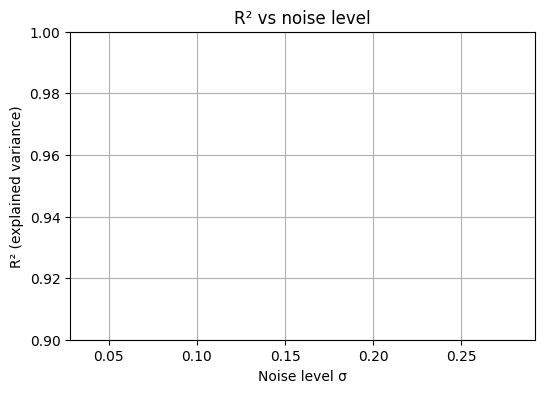

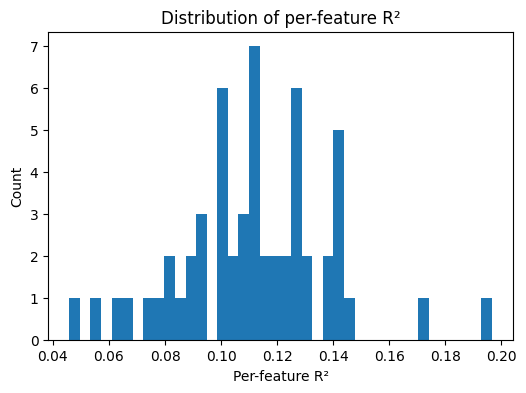

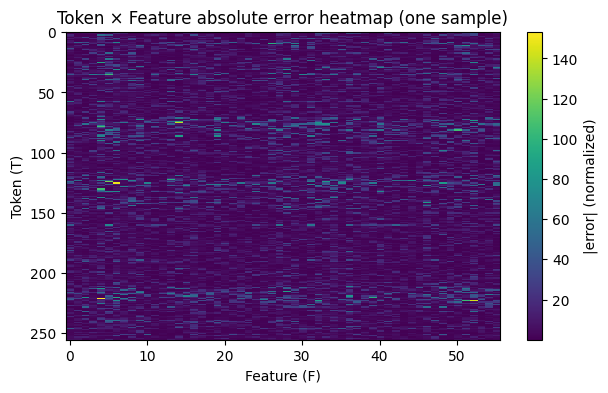

In [11]:
# Evaluate R² vs noise level and per-feature R² heatmap

import matplotlib.pyplot as plt
import numpy as np
import csv
import torch

# Load stats & model
mean = np.load(OUT_DIR / "mean.npy")
std  = np.load(OUT_DIR / "std.npy")
ckpt = torch.load(OUT_DIR / "latent_denoiser_best.pt", map_location="cpu")
meta = ckpt["meta"]; T, F = meta["T"], meta["F"]

# Rebuild model
mdl = TransformerDenoiser(
    feature_dim=F, seq_len=T,
    d_model=meta["d_model"], nhead=meta["nhead"], num_layers=meta["num_layers"],
    dim_feedforward=meta["ff_dim"], dropout=meta["dropout"], time_embed_dim=meta["time_embed_dim"],
).eval()
mdl.load_state_dict(ckpt["model"], strict=False)

def r2_metric(y_true, y_pred):
    err = (y_true - y_pred)
    sse = torch.sum(err * err)
    mu  = torch.mean(y_true)
    sst = torch.sum((y_true - mu)**2) + 1e-12
    return float((1.0 - sse/sst).item())

# Sample some rows for analysis
def sample_rows(csv_files, n=2000):
    rows = []
    per_file = max(1, n // len(csv_files))
    for f in csv_files:
        with open(f, "r", encoding="utf-8") as fh:
            rdr = csv.reader(fh)
            next(rdr, None)
            for i, row in enumerate(rdr):
                if i >= per_file: break
                rows.append(row)
    return rows

rows = sample_rows(csv_files, n=2000)

# Binning by noise level
bins = np.linspace(0.02, 0.30, 8)
bin_r2 = [[] for _ in range(len(bins)-1)]

# Per-feature R² aggregator
feat_num = F
feat_sse = np.zeros((feat_num,), dtype=np.float64)
feat_sst = np.zeros((feat_num,), dtype=np.float64)

for row in rows:
    x = read_row_to_latent(row, T, F)        # [T,F]
    x_norm = (x - mean) / np.clip(std, 1e-6, None)

    # pick a few noise levels to probe
    for nl in [0.05, 0.10, 0.20, 0.30]:
        eps = np.random.randn(*x_norm.shape).astype(np.float32)
        x_noisy = x_norm + nl * eps

        xt = torch.from_numpy(x_norm).unsqueeze(0)   # [1,T,F]
        nt = torch.tensor([nl], dtype=torch.float32)
        xn = torch.from_numpy(x_noisy).unsqueeze(0)

        with torch.no_grad():
            pred_res = mdl(xn, nt)                   # ε̂
            xhat = xn - pred_res                     # x̂_clean

        # overall R² per row
        r2 = r2_metric(xt, xhat)
        b = np.digitize([nl], bins) - 1
        b = int(np.clip(b[0], 0, len(bins)-2))
        bin_r2[b].append(r2)

        # per-feature accumulation
        diff = (xt - xhat).squeeze(0).numpy()        # [T,F]
        mu_f = xt.squeeze(0).numpy().mean(axis=0)    # [F]
        feat_sse += (diff**2).sum(axis=0)
        feat_sst += ((xt.squeeze(0).numpy() - mu_f)**2).sum(axis=0)

# Plot R² vs noise level
bin_centers = 0.5*(bins[:-1] + bins[1:])
avg_r2 = [np.mean(v) if len(v)>0 else np.nan for v in bin_r2]
plt.figure(figsize=(6,4))
plt.plot(bin_centers, avg_r2, marker="o")
plt.ylim(0.9, 1.0)
plt.xlabel("Noise level σ")
plt.ylabel("R² (explained variance)")
plt.title("R² vs noise level")
plt.grid(True)
plt.show()

# Per-feature R² histogram + heatmap of feature errors
feat_r2 = 1.0 - (feat_sse / (feat_sst + 1e-12))
plt.figure(figsize=(6,4))
plt.hist(feat_r2, bins=40)
plt.xlabel("Per-feature R²")
plt.ylabel("Count")
plt.title("Distribution of per-feature R²")
plt.show()

# Optional: token-feature heatmap of average abs error
# Warning: computing full [T,F] heatmap on many samples is heavier; here just one batch
x = read_row_to_latent(rows[0], T, F)
x_norm = (x - mean) / np.clip(std, 1e-6, None)
nl = 0.20
eps = np.random.randn(*x_norm.shape).astype(np.float32)
xn = x_norm + nl * eps
with torch.no_grad():
    pred_res = mdl(torch.from_numpy(xn).unsqueeze(0), torch.tensor([nl]))
    xhat = (torch.from_numpy(xn).unsqueeze(0) - pred_res).squeeze(0).numpy()
abs_err = np.abs(xhat - x_norm)
plt.figure(figsize=(7,4))
plt.imshow(abs_err, aspect='auto', interpolation='nearest')
plt.colorbar(label='|error| (normalized)')
plt.xlabel("Feature (F)")
plt.ylabel("Token (T)")
plt.title("Token × Feature absolute error heatmap (one sample)")
plt.show()


In [33]:
!CUDA_VISIBLE_DEVICES=0 python train.py \
  --data_dir /content/data \
  --out_dir /content/outputs \
  --device cuda \
  --batch_size 32 --grad_accum 2 \
  --epochs 20 --lr 3e-4 --warmup_steps 200 \
  --d_model 512 --ff_dim 2048 --num_layers 10 --nhead 8 \
  --noise_min 0.05 --noise_max 0.30 \
  --noise_min_init 0.02 --noise_max_init 0.15 \
  --curr_warm_epochs 3 --curr_ramp_epochs 3 \
  --target_r2 0.99


[Device] cuda
[Data] shards=1  T=256  F=56
[Stats] Computing mean/std over ~3000 rows…
[Stats] Saved mean/std to /content/outputs
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
/content/train.py:298: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(device=="cuda"))
/content/train.py:358: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device=="cuda")):
/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step

In [34]:
!CUDA_VISIBLE_DEVICES=0 python train2.py \
  --data_dir /content/data \
  --out_dir /content/outputs \
  --device cuda \
  --batch_size 32 --grad_accum 2 \
  --total_steps 10000 --val_every 200 \
  --lr 3e-4 --warmup_steps 500 \
  --d_model 512 --ff_dim 2048 --num_layers 10 --nhead 8 \
  --noise_min 0.05 --noise_max 0.30 \
  --noise_min_init 0.02 --noise_max_init 0.15 \
  --target_r2 0.99


[Device] cuda
[Data] shards=1  T=256  F=56
[Stats] Computing mean/std over ~3000 rows…
[Stats] Saved mean/std to /content/outputs
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
/content/train2.py:313: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(device=="cuda"))
/content/train2.py:359: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device=="cuda")):
/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.st

In [36]:
!CUDA_VISIBLE_DEVICES=0 python test.py \
  --data_dir /content/data \
  --ckpt /content/outputs/latent_denoiser_best.pt \
  --out_dir /content/eval \
  --device cuda \
  --num_rows 2000 \
  --sigmas 0.05,0.10,0.20,0.30 \
  --decode_samples 5


[Device] cuda
[Data] shards=1  T=256  F=56
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
[Eval] sigmas = [0.05, 0.1, 0.2, 0.3]
[Eval] Using 500 rows
/content/test.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast(enabled=(device=="cuda")):
[Eval] Summary:
  sigma_0.05: R2=0.9903, MSE=5.029517
  sigma_0.10: R2=0.9903, MSE=5.037347
  sigma_0.20: R2=0.9902, MSE=5.067969
  sigma_0.30: R2=0.9900, MSE=5.117364
[Eval] Feature-R² mean=0.9870  min=0.9629  max=0.9973
[Write] metrics.json and per_feature_r2.csv in /content/eval
